In [1]:
import os
import jax
import numpy as np
jax.devices()

[CpuDevice(id=0)]

In [2]:
os.chdir("../../..")
from scripts.nj.neurosci import *
import scripts.nj.graph_to_arrays as ga

## Получаем данные

In [3]:
res = ga.load_jax_context("Datasets/Generated/jax/2025d5/test_graph_20n_optimized_params.npz")

Загрузка контекста из: Datasets/Generated/jax/2025d5/test_graph_20n_optimized_params.npz
   Загружено: 2 групп, 3 массивов ребер, 0 массивов признаков.
Контекст симуляции успешно собран из загруженных данных.


In [4]:
stom = jnp.array(res['stom'])

In [5]:
res.keys()

dict_keys(['num_nodes', 'mapping', 'edges_cable_to_cable', 'edges_cable_to_alpha', 'edges_alpha_to_cable', 'stom', 'gnabar_hh', 'gkbar_hh', 'gl_hh', 'L', 'Ra', 'diam', 'el_hh', '__RAW_GLOBAL_MAPPING__', '__RAW_LOCAL_MAPS__'])

In [6]:
stom

Array([[10191936,      132],
       [11531426,     1144],
       [12132809,     1481],
       [12927058,     1828],
       [17855652,     5258],
       [ 1805496,     5361],
       [19255911,     5940],
       [ 2662497,     9022],
       [ 4505350,    10191],
       [ 4982132,    10926],
       [ 5018684,    11025],
       [ 7056349,    11455],
       [ 7810915,    11843],
       [ 7843014,    12032],
       [ 8108327,    12470],
       [ 8250193,    12546],
       [ 8824003,    13248],
       [ 8939282,    13386],
       [ 8981142,    13448],
       [ 9011915,    13726]], dtype=int32)

## Определяем структуру симуляции

In [7]:
a, b = '7055857', '1805418'
ind_to_stim = stom[5][1]
ind_to_stim1 = stom[11][1]
def get_my_pipeline(constants, dt = 0.1):

    cable_m = res['edges_cable_to_cable'].T
    pre_syn = res['edges_cable_to_alpha'].T
    post_syn = res['edges_cable_to_alpha'].T
    
    r = jnp.array(res['diam'])/2
    S = np.pi * r**2

    Rm = 10000 # какое у нас Rm?

    L = jnp.array(res['L'])
    ra = jnp.array(res['Ra']) # аксиональное
    rm = Rm/(np.pi * r) # трансмембранное

    lambda_squared = rm/ra
    tau_hh = ra*rm
    #constants['C'] = constants['C']*tau_hh


    HH = get_HH_pipeline_SGGE(**constants) # получаем функцию для HH
    cable = laplace_at_graph_symetric(cable_m, 'V', scaling = lambda_squared) # получаем функцию для динамики кабелей
    alphaP = get_alpha_synapce_pipeline(pre_syn, post_syn, **constants)
    
    @jax.jit
    def state_transformed(state):
        s, ds = to_diff(state) # создает ds той же формы что и state, но заполненный нулями
        s, ds = alphaP(s, ds)
        s, ds = HH(s, ds) # вставляет HH каналы
        #s, ds = cable(s, ds) # соединяет сегменты
        #ds['V'] += ds['V'].at[ind_to_stim].add(0.7*(s['time'] > 10.0)*(s['time'] < 60.0))
        #ds['V'] += ds['V'].at[ind_to_stim1].add(0.7*(s['time'] > 10.0)*(s['time'] < 60.0))
        return s, ds

    integrate = get_runge_kutta_step(state_transformed, dt) # получаем функцию для интегрирования
    @jax.jit
    def my_pipeline(state):
        s = integrate(state) # интегрируем
        return s
    return my_pipeline


### Начальные значения и константы


In [8]:
num_nodes_hh = res['num_nodes']['cable']
num_synapces = res['num_nodes']['alpha']
total_nodes = num_nodes_hh + num_synapces

initials = {
    "V":jnp.ones((num_nodes_hh, ), jnp.float32)*-65.0,
    "m":jnp.ones((num_nodes_hh, ), jnp.float32)*0.0220,
    'n':jnp.ones((num_nodes_hh, ), jnp.float32)*0.0773,
    'h':jnp.ones((num_nodes_hh, ), jnp.float32)*0.9840,
    'alpha':jnp.ones((num_nodes_hh, 2), jnp.float32)*0.0,
    "time":0.0
}

consts = {
    "C": jnp.ones((num_nodes_hh, ), jnp.float32),# Емкость мембраны (мкФ/см^2)
    "ENa": 50.0,   # Равновесный потенциал Na+ (мВ)
    "EK": -77.0,   # Равновесный потенциал K+ (мВ)
    "EL": -54.4,   # Равновесный потенциал утечки (мВ)
    "gNa": 120.0,  # Максимальная проводимость Na+ (мСм/см^2)
    "gK": 36.0,    # Максимальная проводимость K+ (мСм/см^2)
    "gL": 0.3,     # Проводимость утечки (мСм/см^2),
    "tau":1.0,
    'E_rev':1.0,
    'V_m':jnp.ones((num_nodes_hh, ), jnp.float32),
    'alpha_syn_detector_treshold':40.0,
    'synaptic_weights':0.01,
    'G_max':1.0
}

scale = 1
new_consts = {
    "C": jnp.ones((num_nodes_hh, ), jnp.float32),# Емкость мембраны (мкФ/см^2)
    "ENa": 50.0,   # Равновесный потенциал Na+ (мВ)
    "EK": -77.0,   # Равновесный потенциал K+ (мВ)
    "EL": -54,   # Равновесный потенциал утечки (мВ)
    "gNa": jnp.array(res['gnabar_hh'])*scale,  # Максимальная проводимость Na+ (мСм/см^2)
    "gK": jnp.array(res['gkbar_hh'])*scale,    # Максимальная проводимость K+ (мСм/см^2)
    "gL": jnp.array(res['gl_hh'])*scale,     # Проводимость утечки (мСм/см^2),
    "tau":1.25,
    'E_rev':0.0,
    'V_m':jnp.ones((num_nodes_hh, ), jnp.float32),
    'alpha_syn_detector_treshold':0.5,
    'synaptic_weights':0.5,
    'G_max':1.0
}

SGGE_HH_channel_params = {
        "gNa": 0.12,
        "gK": 0.036,
        "gL": 0.0003,
        "ENa": 50.0,
        "EK": -77.0,
        "EL": -54.3,
    }

CCC = consts | SGGE_HH_channel_params

In [9]:
res['gnabar_hh'].shape

(14409,)

In [10]:
np.mean(np.array(res['gnabar_hh'])*scale)

np.float64(0.036200451469839016)

In [11]:
res.keys()

dict_keys(['num_nodes', 'mapping', 'edges_cable_to_cable', 'edges_cable_to_alpha', 'edges_alpha_to_cable', 'stom', 'gnabar_hh', 'gkbar_hh', 'gl_hh', 'L', 'Ra', 'diam', 'el_hh', '__RAW_GLOBAL_MAPPING__', '__RAW_LOCAL_MAPS__'])

## Запуск симуляции

In [12]:
my_pipeline = get_my_pipeline(new_consts, 0.1)

In [13]:
@jax.jit
def output_transform(state):
    return state['time'], state['V'].at[stom[:, 1]].get()

jsim = simulation(initials, my_pipeline, 10, output_transform)
H = jax.block_until_ready(jsim.run(600))

In [14]:
H

(Array([  1.0000001,   2.0000002,   2.9999993,   3.9999983,   4.9999976,
          5.9999967,   6.9999957,   7.9999948,   8.999998 ,  10.000002 ,
         11.000006 ,  12.00001  ,  13.000013 ,  14.000017 ,  15.000021 ,
         16.000025 ,  17.000029 ,  18.000032 ,  19.000036 ,  20.00004  ,
         21.000044 ,  22.000048 ,  23.000051 ,  24.000055 ,  25.00006  ,
         26.000063 ,  27.000067 ,  28.00007  ,  29.000074 ,  30.000078 ,
         31.000082 ,  32.000084 ,  33.00007  ,  34.000053 ,  35.00004  ,
         36.000023 ,  37.000008 ,  37.999992 ,  38.999977 ,  39.99996  ,
         40.999947 ,  41.99993  ,  42.999916 ,  43.9999   ,  44.999886 ,
         45.99987  ,  46.999855 ,  47.99984  ,  48.999825 ,  49.99981  ,
         50.999794 ,  51.99978  ,  52.999763 ,  53.99975  ,  54.999733 ,
         55.999718 ,  56.999702 ,  57.999687 ,  58.999672 ,  59.999657 ,
         60.99964  ,  61.999626 ,  62.99961  ,  63.999596 ,  64.99958  ,
         65.999565 ,  66.99955  ,  67.999535 ,  68.

In [15]:
np.any(H[1] == np.nan)

Array(False, dtype=bool)

## Построение графиков

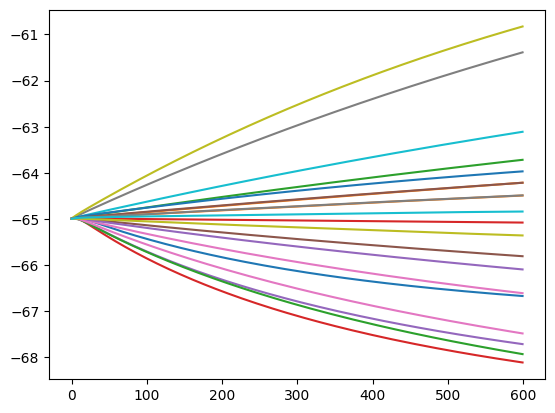

In [16]:
import matplotlib.pyplot as plt
t, v = H
t, v = np.array(t), np.array(v)
plt.plot(v)
plt.show()

- нет четкого соответствия реализации в Neuron
- alpha синапсы вместо exp
- не тот маштаб времени **<- вот основная проблема**
- ~~не те потенциалы покоя, в общем схожи, нижняя граница совпадает, но не верхняя у меня -55. (точно не из за alpha синапсов)~~
- не совпадают стимулы, я подаю ток в 70 мА и ничо не получаю, а должно получатся при 0.7